In [2]:
#https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
import pandas as pd
from pandas import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import datetime as dt
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
t0=dt.datetime.now()
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [4]:
train.shape

(1458644, 11)

In [5]:
test.shape

(625134, 9)

In [6]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [7]:
print ("No need to worry about missing value") if train.count().min()==train.shape[0] else print(" Missing values present")

No need to worry about missing value


In [8]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [9]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)
train.loc[:,'pickup_date']=train.pickup_datetime.dt.date
train.store_and_fwd_flag=1*(train.store_and_fwd_flag.values=='Y')

test.pickup_datetime=pd.to_datetime(test.pickup_datetime)
test.loc[:,'pickup_date']=test.pickup_datetime.dt.date
test.store_and_fwd_flag=1*(test.store_and_fwd_flag.values=='Y')

In [10]:
train.check_trip_duration=(train.dropoff_datetime-train.pickup_datetime).map(lambda x:x.total_seconds())
duration_diff=train[np.abs(train.trip_duration.values-train.check_trip_duration.values)>1]
print('Trip duration times are good...') if duration_diff.shape[0]==0 else print('OOps')

Trip duration times are good...


In [11]:
train['trip_duration'].max()//3600

979

In [12]:
train['log_trip_duration']=np.log(train.trip_duration.values+1)

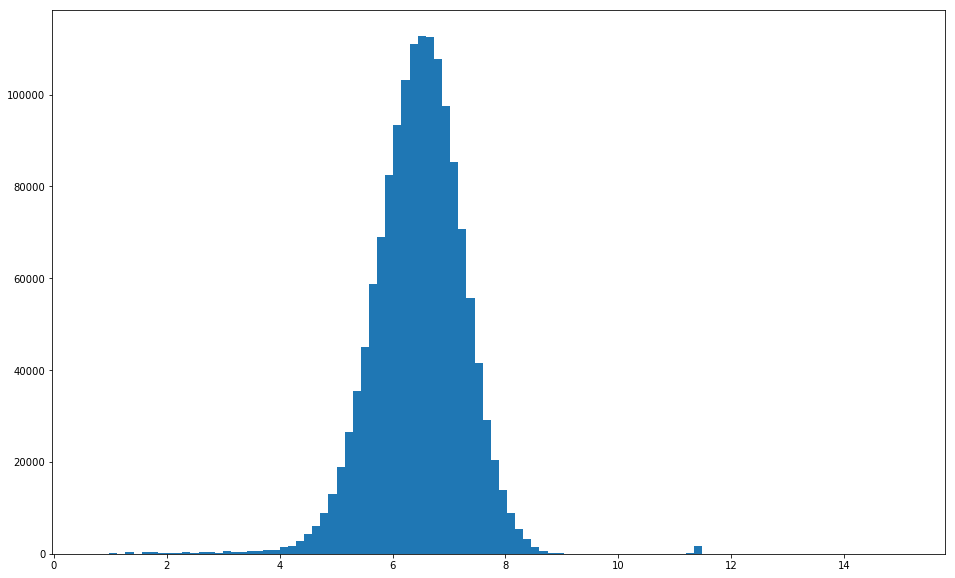

In [13]:
plt.hist(train['log_trip_duration'].values,bins=100)
plt.show()


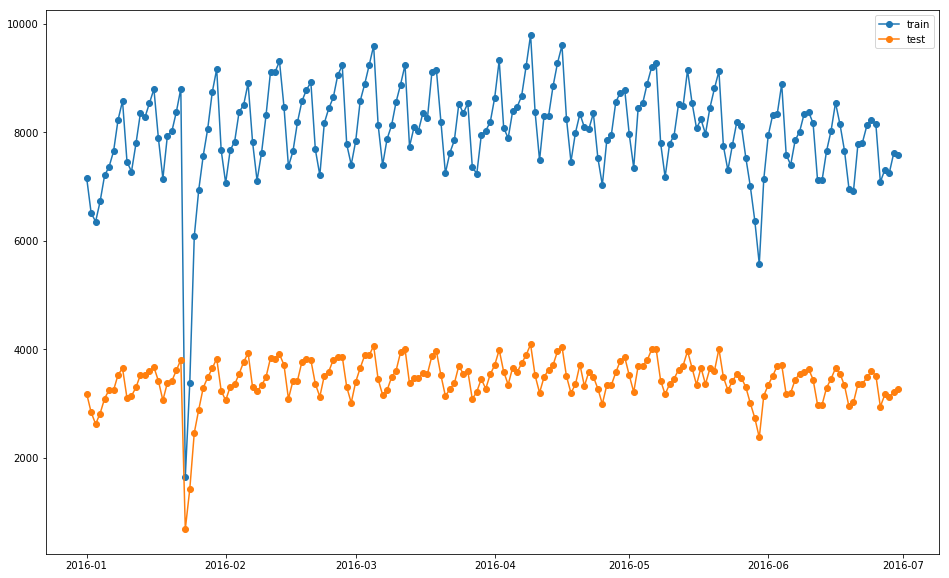

In [14]:
plt.plot(train.groupby('pickup_date').count()['id'],'o-',label='train')
plt.plot(test.groupby('pickup_date').count()['id'],'o-',label='test')
plt.legend(loc=0)
plt.figure(figsize=(5,1))
plt.show()

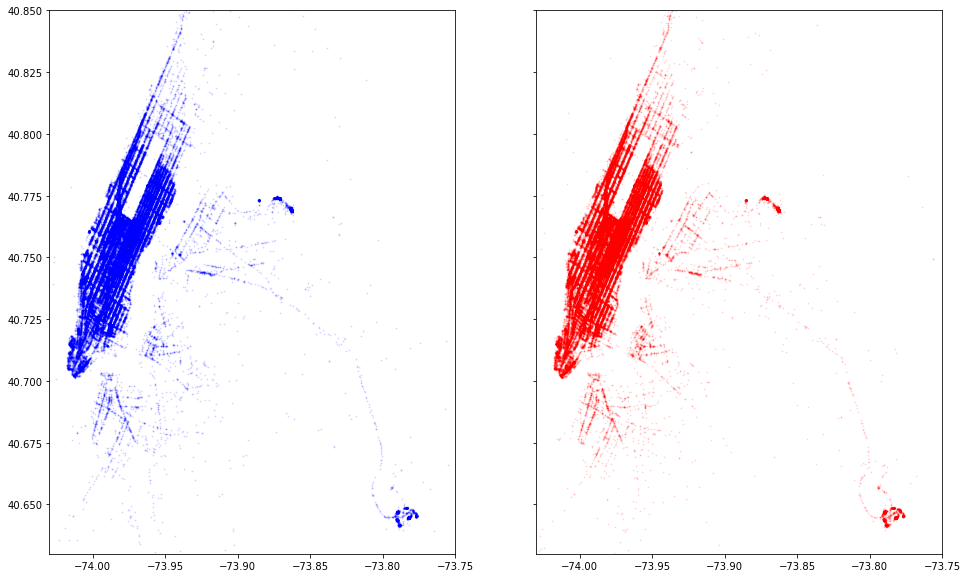

In [15]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig,ax=plt.subplots(ncols=2,sharex=True,sharey=True)
N=100000
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue',label='train')
ax[1].scatter(test['pickup_longitude'].values[:N],test['pickup_latitude'].values[:N],s=1,alpha=.1,color='red',label='test')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [16]:
#Feature extraction
#PCA
coords=np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                  train[['dropoff_latitude','dropoff_longitude']].values,
                 test[['pickup_latitude','pickup_longitude']].values,
                 test[['dropoff_latitude','dropoff_longitude']].values))
pca=PCA().fit(coords)

train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]


test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]

(-0.13426186697746503, 0.1017816834266389)

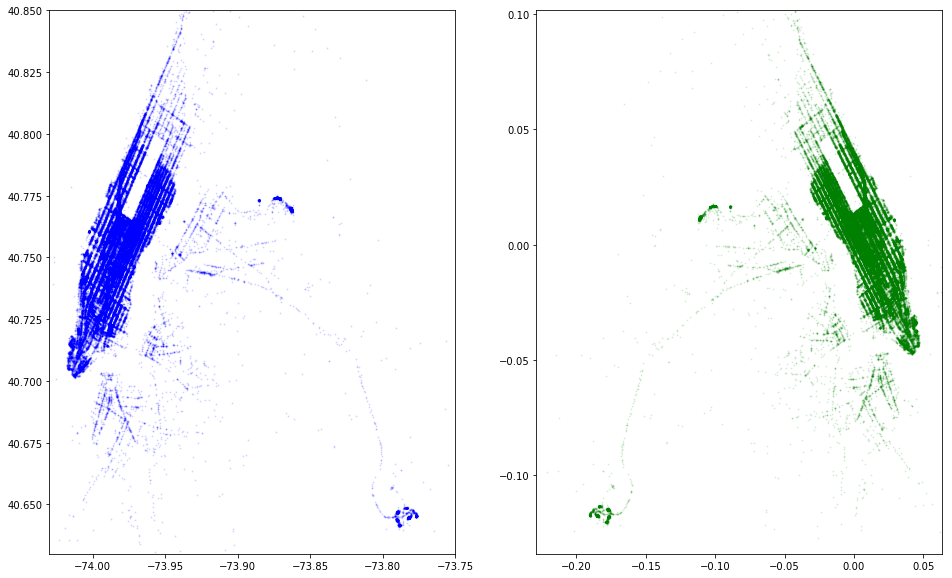

In [17]:
fig,ax=plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue')
ax[1].scatter(train['pickup_pca0'].values[:N],train['pickup_pca1'].values[:N],s=1,alpha=.1,color='green')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders=pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(),pca_borders[:,0].max())
ax[1].set_ylim(pca_borders[:,1].min(),pca_borders[:,1].max())

In [18]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [19]:
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                  train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                                 train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                      train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])

In [20]:
test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                  test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                                 test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                      test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])

In [21]:
train.loc[:,'center_latitude']=(train['pickup_latitude'].values+train['dropoff_latitude'].values)/2
train.loc[:,'center_longitude']=(train['pickup_longitude'].values+train['dropoff_longitude'].values)/2
test.loc[:,'center_latitude']=(test['pickup_latitude'].values+test['dropoff_latitude'].values)/2
test.loc[:,'center_longitude']=(test['pickup_longitude'].values+test['dropoff_longitude'].values)/2

In [22]:
#Datetime Features

In [23]:
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_weekofyear']=train.pickup_datetime.dt.weekofyear
train.loc[:,'pickup_hour']=train.pickup_datetime.dt.hour
train.loc[:,'pickup_minute']=train.pickup_datetime.dt.minute
train.loc[:,'pickup_weekhour']=(train.pickup_datetime.dt.weekday*24)+train.pickup_datetime.dt.hour

In [24]:
test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'pickup_weekofyear']=test.pickup_datetime.dt.weekofyear
test.loc[:,'pickup_hour']=test.pickup_datetime.dt.hour
test.loc[:,'pickup_minute']=test.pickup_datetime.dt.minute
test.loc[:,'pickup_weekhour']=(test.pickup_datetime.dt.weekday*24)+test.pickup_datetime.dt.hour

In [25]:
#speed

In [26]:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']

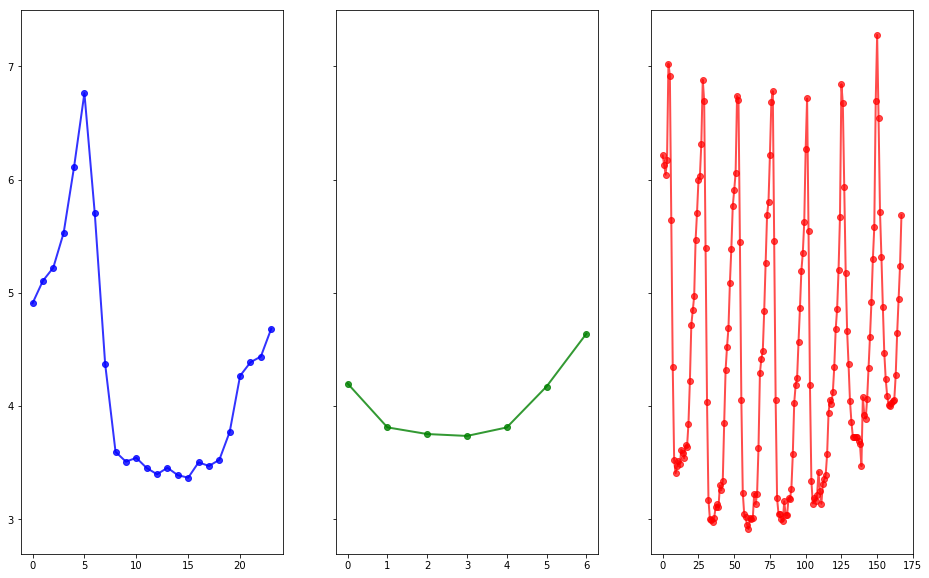

In [27]:
fig,ax=plt.subplots(ncols=3,sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'],'bo-',lw=2,alpha=.8)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'],'go-',lw=2,alpha=.8)
ax[2].plot(train.groupby('pickup_weekhour').mean()['avg_speed_h'],'ro-',lw=2,alpha=.7)

In [28]:
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'].values,3)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'].values,3)

gby_cols=['pickup_lat_bin','pickup_long_bin']
coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
coord_status=pd.merge(coord_speed,coord_count,on=gby_cols)
coord_status=coord_status[coord_status['id']>100]

(40.63, 40.85)

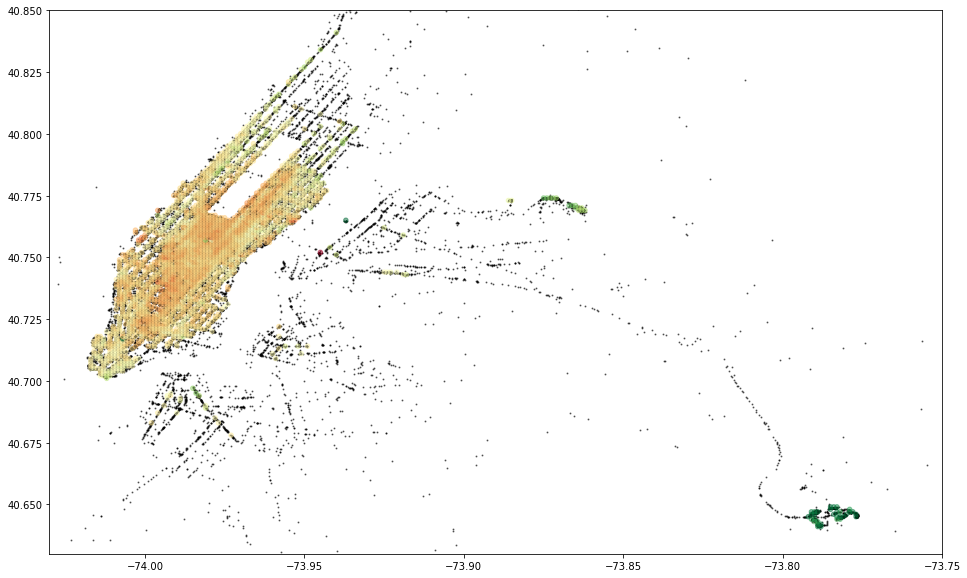

In [29]:
fig,ax=plt.subplots(ncols=1,nrows=1)
ax.scatter(train.pickup_longitude.values[:N],train.pickup_latitude.values[:N],color='black',s=1,alpha=.5)
ax.scatter(coord_status.pickup_long_bin.values,coord_status.pickup_lat_bin.values,
           c=coord_status.avg_speed_h.values,cmap='RdYlGn',s=20,alpha=0.5,vmin=1,vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

In [30]:
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],2)
train.loc[:,'center_lat_bin']=np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin']=np.round(train['center_longitude'],2)

test.loc[:,'pickup_lat_bin']=np.round(test['pickup_latitude'],2)
test.loc[:,'pickup_long_bin']=np.round(test['pickup_longitude'],2)
test.loc[:,'center_lat_bin']=np.round(test['center_latitude'],2)
test.loc[:,'center_long_bin']=np.round(test['center_longitude'],2)

In [31]:
#clustering

In [32]:
sample_ind=np.random.permutation(len(coords))[:500000]
kmeans=MiniBatchKMeans(n_clusters=100,batch_size=10000).fit(coords[sample_ind])

In [33]:
train.loc[:,'pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
test.loc[:,'pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test.loc[:,'dropoff_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])

(40.63, 40.85)

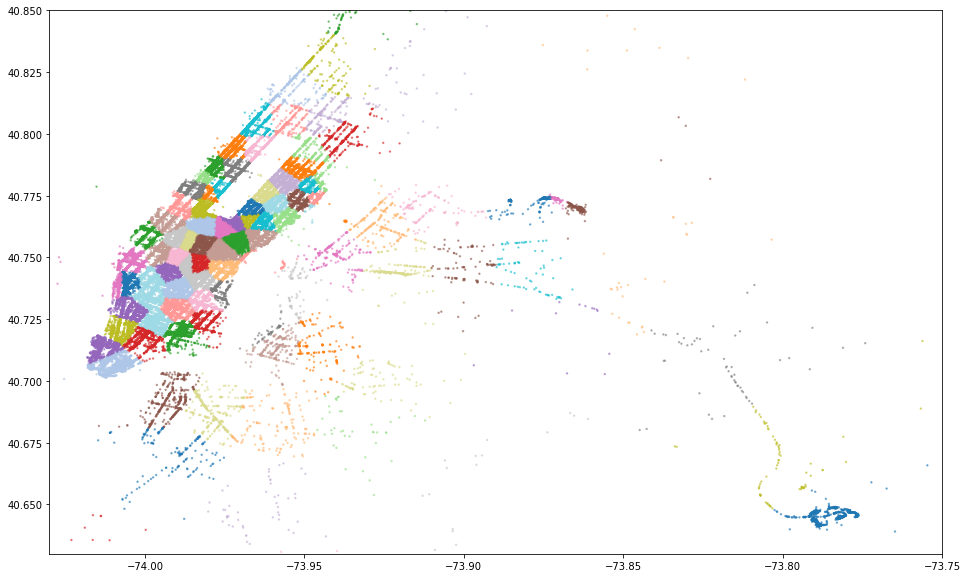

In [34]:
fig,ax=plt.subplots(ncols=1,nrows=1)
ax.scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=2,alpha=.5,
           c=train['pickup_cluster'].values[:N],cmap='tab20')
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)

In [35]:
#Temporal and geospatial aggregation

In [36]:
for gby_cols in ['pickup_hour','pickup_date','pickup_weekhour','pickup_cluster','dropoff_cluster']:
    gby=train.groupby(gby_cols).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    gby.columns=['%s_gby_%s' % (col,gby_cols) for col in gby.columns]
    train=pd.merge(train,gby,how='left',left_on=gby_cols,right_index=True)
    test=pd.merge(test,gby,how='left',left_on=gby_cols,right_index=True)

In [37]:
for gby_cols in [['center_lat_bin','center_long_bin'],['pickup_hour','center_lat_bin','center_long_bin'],
                ['pickup_hour','pickup_cluster'],['pickup_hour','dropoff_cluster'],
                ['pickup_cluster','dropoff_cluster']]:
    coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats=pd.merge(coord_speed,coord_count,on=gby_cols)
    coord_stats=coord_stats[coord_stats['id']>100]
    coord_stats.columns=gby_cols+['avg_speed_h_%s' % '_'.join(gby_cols),'cnt_%s' % '_'.join(gby_cols)]
    train=pd.merge(train,coord_stats,how='left',on=gby_cols)
    test=pd.merge(test,coord_stats,how='left',on=gby_cols)

In [38]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')

In [39]:
dropoff_counts=df_all.set_index('pickup_datetime')\
.groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster'])\
.agg({'id':'count'})\
.reset_index().set_index('pickup_datetime')\
.groupby('dropoff_cluster').rolling('240min').mean()\
.drop('dropoff_cluster',axis=1)\
.reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index()\
.rename(columns={'pickup_datetime':'pickup_datetime_group','id':'dropoff_cluster_count'})

In [40]:
train['dropoff_cluster_count']=pd.merge(train,dropoff_counts,how='left',on=['pickup_datetime_group', 'dropoff_cluster'])['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count']=pd.merge(test,dropoff_counts,how='left',on=['pickup_datetime_group', 'dropoff_cluster'])['dropoff_cluster_count'].fillna(0)

In [41]:
#OSRM Features

In [42]:
fr1=pd.read_csv('fastest_routes_train_part_1.csv.zip',usecols=['id','total_distance','total_travel_time','number_of_steps'])
fr2=pd.read_csv('fastest_routes_train_part_2.csv.zip',usecols=['id','total_distance','total_travel_time','number_of_steps'])
test_street_info=read_csv('fastest_routes_test.csv.zip',usecols=['id','total_distance','total_travel_time','number_of_steps'])


In [43]:
train_street_info=pd.concat([fr1,fr2])
train=pd.merge(train,train_street_info,how='left',on='id')
test=pd.merge(test,test_street_info,how='left',on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [44]:
feature_names=list(train)
print(np.setdiff1d(train.columns,test.columns))

['avg_speed_h' 'avg_speed_m' 'dropoff_datetime' 'log_trip_duration'
 'trip_duration']


In [45]:
print(feature_names)

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'log_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_weekhour', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_weekhour', 'avg_speed_m_gby_pickup_weekhour', 'log_trip_duration_gby_pickup_weekhour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m

In [46]:
do_not_use_for_training=['id','log_trip_duration','pickup_datetime','dropoff_datetime',
                        'trip_duration','check_trip_duration','pickup_date','avg_speed_h','avg_speed_m',
                        'pickup_lat_bin','pickup_long_bin','center_lat_bin','center_long_bin',
                        'pickup_dt_bin','pickup_datetime_group']
feature_names=[f for f in feature_names if f not in do_not_use_for_training]

In [47]:
print(feature_names)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_weekhour', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_weekhour', 'avg_speed_m_gby_pickup_weekhour', 'log_trip_duration_gby_pickup_weekhour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip_duration_gby_pickup_cluster', 'avg_speed_h_gby_dropoff_cluster', 'avg_speed_m_gby_dropoff_cluster', 'log_trip_duration_gby_dropoff_cluster', 'avg_speed_h_center_lat_bin_c

In [48]:
print('we have %i features' % len(feature_names))

we have 54 features


In [49]:
train[feature_names].count()

vendor_id                                                 1458644
passenger_count                                           1458644
pickup_longitude                                          1458644
pickup_latitude                                           1458644
dropoff_longitude                                         1458644
dropoff_latitude                                          1458644
store_and_fwd_flag                                        1458644
pickup_pca0                                               1458644
pickup_pca1                                               1458644
dropoff_pca0                                              1458644
dropoff_pca1                                              1458644
distance_haversine                                        1458644
distance_dummy_manhattan                                  1458644
direction                                                 1458644
pca_manhattan                                             1458644
center_lat

In [50]:
y=np.log(train['trip_duration'].values+1)
t1=dt.datetime.now()

In [51]:
print('Feature extraction time :%i seconds' %(t1-t0).seconds)

Feature extraction time :145 seconds


In [52]:
#Feature check before modeling

In [53]:
feature_stats=pd.DataFrame({'feature':feature_names})
feature_stats.loc[:,'train_mean']=np.nanmean(train[feature_names].values,axis=0).round(4)
feature_stats.loc[:,'test_mean']=np.nanmean(test[feature_names].values,axis=0).round(4)

feature_stats.loc[:,'train_std']=np.nanstd(train[feature_names].values,axis=0).round(4)
feature_stats.loc[:,'test_std']=np.nanstd(test[feature_names].values,axis=0).round(4)




In [54]:
feature_stats.loc[:,'train_nan']=np.mean(np.isnan(train[feature_names].values),axis=0).round(3)
feature_stats.loc[:,'test_nan']=np.mean(np.isnan(test[feature_names].values),axis=0).round(3)

feature_stats.loc[:,'train_test_mean_diff']=np.abs(feature_stats['train_mean']-feature_stats['test_mean'])/\
np.abs(feature_stats['train_std']+feature_stats['test_std'])*2

feature_stats.loc[:,'train_test_nan_diff']=np.abs(feature_stats['train_nan']-feature_stats['test_nan'])

feature_stats=feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature','train_mean','test_mean','train_test_mean_diff']].tail()

,feature,train_mean,test_mean,train_test_mean_diff
37,avg_speed_m_gby_dropoff_cluster,5.1805,5.1780,0.002490
39,avg_speed_h_center_lat_bin_center_long_bin,3.9739,3.9712,0.002543
7,pickup_pca0,0.0000,0.0002,0.002774
10,dropoff_pca1,0.0004,0.0005,0.002833
18,pickup_weekofyear,13.8399,13.8645,0.002872


In [55]:
feature_stats=feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature','train_nan','test_nan','train_test_nan_diff']].tail

<bound method NDFrame.tail of                                               feature  train_nan  test_nan  \
29                  log_trip_duration_gby_pickup_date      0.000     0.000   
17                                     pickup_weekday      0.000     0.000   
2                                    pickup_longitude      0.000     0.000   
9                                        dropoff_pca0      0.000     0.000   
4                                   dropoff_longitude      0.000     0.000   
52                                  total_travel_time      0.000     0.000   
40                 cnt_center_lat_bin_center_long_bin      0.009     0.009   
14                                      pca_manhattan      0.000     0.000   
32              log_trip_duration_gby_pickup_weekhour      0.000     0.000   
11                                 distance_haversine      0.000     0.000   
51                                     total_distance      0.000     0.000   
46                    cnt_pickup_h

In [56]:
#modeling

In [57]:
Xtr,Xv,Ytr,Yv=train_test_split(train[feature_names].values,y,test_size=.2,random_state=1987)

In [58]:
dtrain = xgb.DMatrix(Xtr, label=Ytr)
dvalid = xgb.DMatrix(Xv, label=Yv)
dtest = xgb.DMatrix(test[feature_names].values)

watchlist=[(dtrain,'train'),(dvalid,'valid')]

In [59]:
xgb_pars={'min_child_weight':50,'eta':0.3,'colsample_bytree':.3,'max_depth':10,
         'subsample':.8,'lambda':1,'nthread':4,'booster':'gbtree','silent':1,
         'eval_metric':'rmse','objective':'reg:linear'}

In [60]:
model=xgb.train(xgb_pars,dtrain,60,watchlist,early_stopping_rounds=50,maximize=False,verbose_eval=10)

[0]	train-rmse:4.2253	valid-rmse:4.22643
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.405011	valid-rmse:0.418573
[20]	train-rmse:0.372328	valid-rmse:0.391666
[30]	train-rmse:0.363875	valid-rmse:0.388329
[40]	train-rmse:0.357469	valid-rmse:0.386295
[50]	train-rmse:0.352679	valid-rmse:0.385198
[59]	train-rmse:0.35019	valid-rmse:0.385249


In [61]:
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.38496


In [76]:
#Feature important analysis
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 
                   0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 
                   0.38754, 0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 
                   0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 
                   0.38782, 0.38673, 0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 
                   0.38690, np.nan, np.nan, np.nan]

feature_importance_dict=model.get_fscore()
fs=['f%i' %i for i in range(len(feature_names))]
f1=pd.DataFrame({'f':list(feature_importance_dict.keys()),'importance':list(feature_importance_dict.values())})
f2=pd.DataFrame({'f':fs,'feature_name':feature_names,'rmse_wo_feature':rmse_wo_feature})

feature_importance=pd.merge(f1,f2,how='right',on='f')
feature_importance=feature_importance.fillna(0)

feature_importance[['feature_name','importance','rmse_wo_feature']].sort_values(by='importance',ascending=False)

,feature_name,importance,rmse_wo_feature
7,dropoff_pca1,1199,0.38738
26,pickup_longitude,921,0.38726
13,direction,900,0.39359
9,pca_manhattan,809,0.38672
29,dropoff_pca0,775,0.38767
34,center_latitude,717,0.38794
21,pickup_latitude,711,0.38780
1,total_travel_time,708,0.00000
3,distance_dummy_manhattan,676,0.38678
24,avg_speed_h_center_lat_bin_center_long_bin,672,0.38734


In [72]:
len(rmse_wo_feature)

59

In [73]:
len(feature_names)

54